In [86]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

In [87]:
# waitlist and enrollment data
wl=pd.read_csv("onlywaitlists.csv")
# sum together enrollment and waitlist data
wl_data=wl.groupby(['Class']).sum().reset_index()
# drop the row the totals waitlist number per class
waitlist_poisson_parameters = wl_data.loc[:, "Total"]/2

def simulate_student(poisson_parameters):
    utility = np.zeros(len(poisson_parameters))
    for i in range(len(utility)):
        utility[i] = np.round(np.random.poisson(poisson_parameters[i]), 3)
    return utility

# Checking reasonableness of utility function
print(simulate_student(waitlist_poisson_parameters))

[ 14.  97.   9.  39.   4.  24.  15.   0. 123. 140.   2.  26.  43. 226.
 174. 275. 234. 190.  39.  59.  36.  34. 253.  12.   4.  26.  35.  28.
 129. 134.  18. 133.  48.  84.   0. 185.  12. 135.  65.   2.  32.  98.
  95.   0.]


In [88]:
# combinations of length n
def combinations(array, tuple_length, prev_array=[]):
    if len(prev_array) == tuple_length:
        return [prev_array]
    combs = []
    for i, val in enumerate(array):
        prev_array_extended = prev_array.copy()
        prev_array_extended.append(val)
        combs += combinations(array[i+1:], tuple_length, prev_array_extended)
    return combs

# all bundles below a maximum length. Greedy version, definitely a better way exists
def powerset(omega, max_length):
    subsets = []
    for i in range(max_length):
        subsets += combinations(omega, i+1)
    return subsets

# turns a bundle into corresponding allocation vector in R^m
def bundle_to_allocation(bundle, n):
    allocation = np.zeros(n)
    for i in bundle:
        allocation[i-1] = 1
    return allocation

# costs for an allocation vector
def cost(allocation, prices):
    return np.dot(allocation, prices)

In [89]:
# Input: Max bundle size
# Output: set of possible allocation vectors
def allocations(max_length, n):
    omega = np.array(range(1, n+1))
    feasible_bundles = powerset(omega, max_length)
    allocations = []
    for i in feasible_bundles:
        allocations.append(bundle_to_allocation(i, n))
    return allocations

In [90]:
# input: set of allocations, utility, prices, and budget
# output: utility-maximizing budget-feasible bundles

# note: not always unique
def demand_set(allocations, prices, utility, budget):
    demand_set = []

    max_u = 0
    for i in allocations:
        feasible = (cost(i, prices) <= budget)
        if feasible:
            u = np.dot(i, utility)
            if u < max_u:
                continue
            elif u == max_u:
                demand_set.append(i)
            elif u > max_u:
                max_u = u
                demand_set.clear()
                demand_set.append(i)
    
    return np.asarray(demand_set)

In [91]:
#Please make e/d a whole number for now

def budget_intervals(bundles, prices, utility, budget, delta, epsilon):
    discontinuities = []
    allocations = []
    lower = budget-epsilon
    current_demand = demand_set(bundles, prices, utility, lower)

    #find closest multiple of delta to lower
    current_budget = lower

    while (current_budget < budget+epsilon):
        new_budget = current_budget + delta
        new_demand = demand_set(bundles, prices, utility, new_budget)
        if (np.array_equal(new_demand, current_demand)):
            pass
        else:
            for j in range(len(current_demand)):
                discontinuities.append(new_budget)
                allocations.append(current_demand[j])
            current_demand = new_demand
        current_budget += delta

    final_demand = demand_set(bundles, prices, utility, budget+epsilon)
    for j in range(len(final_demand)):
        discontinuities.append(budget+epsilon)
        allocations.append(final_demand[j])

    # This returns two lists.
    # For a given index i,
        # discontinuities[i] is some budget, which is a multiple of delta
        # Denote this budget as D
        # allocations[i] is a an allocation vector (e.g. [0, 0, 1, 0, 0, 1]) that was in demand set for budget D.
    # 
    # TLDR, allocations[i] is a vector, and discontinuities[i] is the budget for which that vector was in demand set.
    return discontinuities, allocations


In [92]:
def clearing_error_optimizer(a, c, p):

    # Define n, m
    # n = no. of studnets
    # m = no. of classes
    n = len(a)
    m = len(c)

    # Create a new model
    model = gp.Model("Clearing_Error_Minimization")

    # Variables

    # clearing error variables
    z = model.addVars(m, vtype=GRB.INTEGER, name="z")
    y = model.addVar(name="y")

    # Indicator variable for budget intervals. Modified because k_i might be different for each student
    x = []
    for i in range(n):
        k = len(a[i])
        x.append(model.addVars(k, vtype=GRB.BINARY))


    # OBJECTIVE: minimize y, which will be equal to the 1-norm of z
    model.setObjective(y, sense=GRB.MINIMIZE)


    # Constraints

    #Set y == ||z||_1
    model.addGenConstrNorm(y, z, 1.0, "normconstr")

    # One schedule per student
    for i in range(n):
        k = len(x[i])
        model.addConstr(gp.quicksum(x[i][l] for l in range(k)) == 1, name="maximum one schedule")

    # Integral allocations already accounted for because x variables are GRB.BINARY

    # Clearing error constraints:
    # gp.quicksum(x[i][l] * a[i][l][j] for i in range(n) for l in range(len(x[i])))
    for j in range(m):
        if (p[j] > 0):
            model.addConstr(gp.quicksum(x[i][l]*a[i][l][j] for i in range(n) for l in range(len(x[i]))) <= c[j] + z[j], name = f"z equality {j}")
        elif (p[j] == 0):
            model.addConstr(gp.quicksum(x[i][l]*a[i][l][j] for i in range(n) for l in range(len(x[i])) ) <= c[j] + z[j], name = f"z inequality {j}")
        
    model.optimize()
    if model.status == GRB.OPTIMAL:
        optimal_obj = model.ObjVal
        schedules = []
        for i in range(len(x)):
            schedules.append(np.array([x[i][j].X for j in range(len(x[i]))]))
        error = np.array([z[i].X for i in range(len(z))])
        return schedules, error, optimal_obj
    else:
        print(f"Optimization terminated with status {model.status}")
		# Check if the model is infeasible
        model.computeIIS()
        print("\nInfeasible constraints:")
        for c in model.getConstrs():
            if c.IISConstr:
                print(c.constrName)
        return (None, None)



In [93]:
def ACEEI(u, c, budgets, K, delta, epsilon):
    p = np.zeros(len(c))
    bundles = allocations(max_length=K, n = len(c))
    
    epoch = 0
    optimum = 9999999
    clearing_error = []
    while (optimum > 0):
        print(f"Epoch {epoch}")
        a = []
        for i in range(len(u)):
            demands = budget_intervals(bundles, p, u[i], budgets[i], delta, epsilon)[1]
            if len(demands) == 0:
                print(f"AGENT {i} HAS NO DEMAND SET!!, TRY AGAIN WITH SMALLER STEP SIZE!!")
                return None
            a.append(demands)
        
        print("demands found")
            
        
        x, z, optimum = clearing_error_optimizer(a, c, p)


        print("\n\n")
        #for i in range(len(u)):
        #    #note extra zeros because np.where has strange return type
        #    index = np.where(x[i] == 1)[0][0]
        #    print(f"BUNDLE FOR STUDENT {i} == ", a[i][index][0])

        if (optimum == 0):
            print("ZERO CLEARING ERROR")
            return a, x, z, p, clearing_error
        else:
            p = p + delta*z
            clearing_error.append(optimum)
            print("CLEARING ERROR     == ", optimum)
            print("Z vector: ", z)
            print("\nNEW PRICES         == ", p, "\n\n")


        
        epoch += 1

    return a, x, z, p, clearing_error

## A-CEEI

Inputs 
* Student's utility functions $u_i$
* Course capacities $c$
* Initial budgets b_0
* maximum bundle size K

Parameters
* Step size $\delta$
* Max. budget perturbation $\epsilon$

Outputs
* Final prices $p^* \in \mathbb{R}^m$
* Final budgets $b^* \in \mathbb{R}^n$

### Description

1) Take in $u, c, b_0$.
2) Set p = 0.
3) Find demand sets within the allowed budget perturbation.
4) With these demand sets for each student, try to find the lowest clearing error.
5) If clearing error is 0:
    * terminate
6) Otherwise, update prices, and repeat from step 3.

In [94]:
# K is max. number of classes
# N is max. number of students
K = 3
N = 30
delta = .001
epsilon = .001

In [95]:
# budgets
budgets = np.ones(N)

# utilities
u = []
for i in range(N):
    u.append(simulate_student(waitlist_poisson_parameters))

#capacities
capacities = np.round(wl_data.loc[:, "Cap"]/50, 0)
print(sum(capacities))

164.0


In [96]:
result = ACEEI(u, capacities, budgets, K, delta, epsilon)

Epoch 0
demands found
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C64)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 74 rows, 75 columns and 164 nonzeros
Model fingerprint: 0x4881ba44
Model has 1 general constraint
Variable types: 1 continuous, 74 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 74 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 10 available processors)

Solution count 1: 59 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.900000000000e+01, best bound 5.900000000000e+01, gap 0.0000%



CLEARING ERROR     ==  59.0
Z vector:  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. 

In [97]:
print("PRICES = ", result[3])
print("CLEARING ERROR = ", result[2])
#for i in range(len(u)):
#    print(f"INDICATOR VECTOR FOR STUDENT {i} = ", result[1][i])
#for i in range(len(u)):
    #note extra zeros because np.where has strange return type
#    index = np.where(result[1][i] == 1)[0][0]
#    print(f"BUNDLE FOR STUDENT {i} == ", result[0][i][index])

PRICES =  [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.609 0.243 0.756 0.599 0.288 0.    0.    0.    0.    0.712 0.
 0.    0.    0.    0.    0.    0.066 0.    0.154 0.    0.    0.    0.335
 0.    0.13  0.    0.    0.    0.    0.    0.   ]
CLEARING ERROR =  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0.]


In [98]:
#Compute social welfare for a given allocation across all agents
def utilitarian_social_welfare(budgets, utility, x, a):
    allocations = []
    for i in range(len(x)):
        index = np.where(x[i] == 1)[0][0]
        allocations.append(a[i][index])
    
    total = 0
    sum_of_budgets = np.sum(budgets)

    #n = len(budgets)

    for i in range(len(budgets)):
        weight = (budgets[i]/sum_of_budgets)
        total = total + weight * np.dot(utility[i], allocations[i])

        #NSW below
        #total = total*np.power(np.dot(utility[i], allocations[i]), 1/n)
    return total 

print("Budget-weighted social welfare: ", utilitarian_social_welfare(budgets, u, result[1], result[0]))

Budget-weighted social welfare:  583.9333333333333


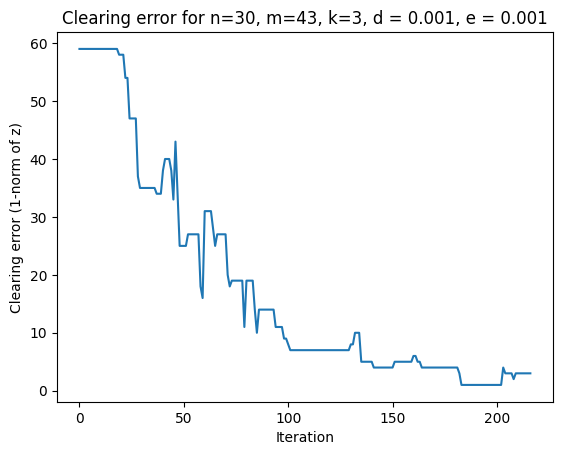

In [99]:
error = result[4]
x_axis = np.array(range(0, len(error)))
plt.plot(x_axis, error)
plt.ylabel("Clearing error (1-norm of z)")
plt.xlabel("Iteration")
plt.title(f"Clearing error for n={N}, m={43}, k={K}, d = {delta}, e = {epsilon}")
plt.show()